# Supernova distances and redshifts (Part 1)

# Examinable
- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

In [152]:
import numpy as np
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

In [153]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Data Exploration

Text(0.5, 1.0, 'Raw Data')

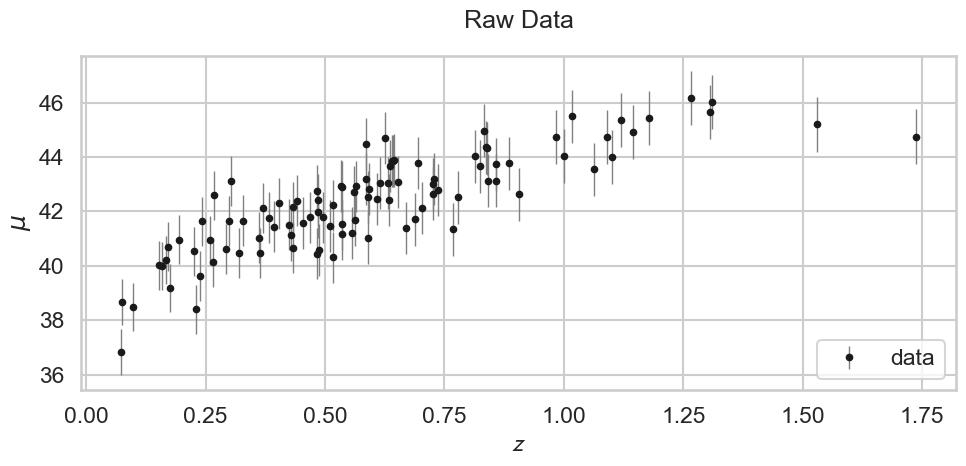

In [154]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$\mathcal{z}$")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.title('Raw Data')

In [155]:
data = pd.DataFrame(
    {'z' : z_sample,
     'mu' : mu_sample,
     'dmu' : dmu}
)

In [156]:
from scipy.stats import norm, kstest

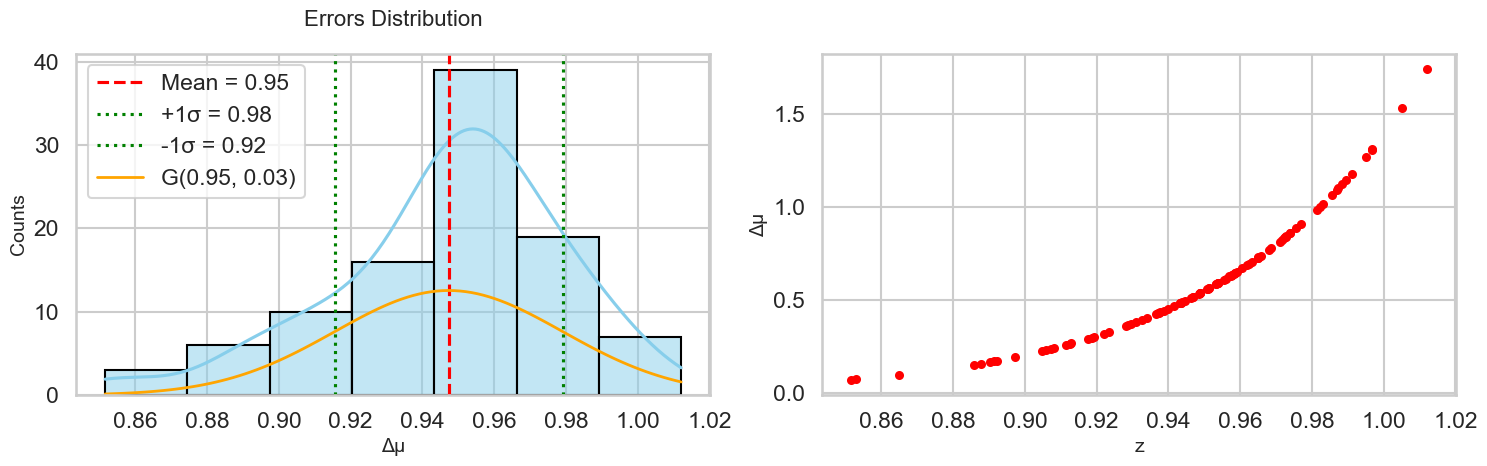

In [157]:
sns.set_theme(style="whitegrid", context="talk")
dmu_fit = np.linspace(min(dmu), max(dmu), 100)
# Compute stats
mean = data['dmu'].mean()
std = data['dmu'].std()
n = norm(mean, std).pdf(dmu_fit)
# Plot
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.histplot(data['dmu'], bins='scott', kde=True, color='skyblue', edgecolor='black')

# Add vertical lines for mean and ±1σ
plt.axvline(mean, color='red', linestyle='--', label=f'Mean = {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle=':', label=f'+1σ = {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle=':', label=f'-1σ = {mean - std:.2f}')
plt.plot(dmu_fit, n, color='orange', lw=2, label=f'G({mean:.2f}, {std:.2f})')

# Labels and title
plt.xlabel("Δμ", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("Errors Distribution", fontsize=16)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(dmu, z_sample, lw=2, color='red', marker='.')
plt.xlabel("z", fontsize=14)
plt.ylabel("Δμ", fontsize=14)
plt.tight_layout()


Is the error distribution gaussian? $\to$ Kolmogorov-Smirnoff test

In [158]:
mu, sigma = np.mean(dmu), np.std(dmu)
ks_stat, ks_p = kstest(dmu, 'norm', args=(mu, sigma))
print('Threshold : 5%')
print(f"Kolmogorov–Smirnov Test:\nStatistic = {ks_stat:.4f}, p-value = {ks_p*100:.4} %")
print(f'Gaussian distribution moments: mu = {mu:.2}, sigma = {sigma:.2}')

Threshold : 5%
Kolmogorov–Smirnov Test:
Statistic = 0.1088, p-value = 17.43 %
Gaussian distribution moments: mu = 0.95, sigma = 0.032


So I have not strong enough evidence to reject the null hypothesis ('Errors distribution is normal'). I am facing a regression task were my sample exhibits homoscedastic Gaussian errors.

In [159]:
import random
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

In [160]:
X = np.vstack([z_sample, mu_sample, dmu]).T

In [161]:
from sklearn.model_selection import train_test_split

In [162]:
X_train, temp = train_test_split(X, test_size=0.6, shuffle=True, random_state=42)
X_test, X_cv = train_test_split(temp, test_size=0.5, shuffle=True, random_state=42)

Text(0.5, 1.0, 'Raw Data')

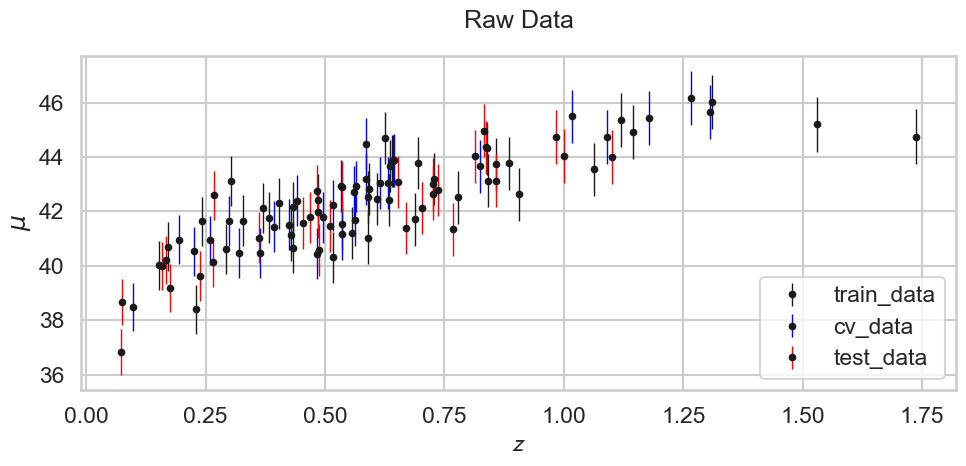

In [163]:
plt.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.k', ecolor='k', lw=1,label='train_data')
plt.errorbar(X_cv[:, 0], X_cv[:, 1], yerr=X_cv[:, 2], fmt='.k', ecolor='blue', lw=1,label='cv_data')
plt.errorbar(X_test[:, 0], X_test[:, 1], yerr=X_test[:, 2], fmt='.k', ecolor='red', lw=1,label='test_data')
plt.xlabel(r"$\mathcal{z}$")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.title('Raw Data')

## Linear Regression

In [164]:
from sklearn.linear_model import LinearRegression

In [165]:
def compute_ci(z, mu, y_pred):
    # Calculate confidence interval
    n = len(z)
    z_sorted = np.sort(z)
    X_design = np.vstack([np.ones(n), z]).T
    pred_var = np.sum((mu - y_pred)**2) / (n - 2)
    XTX_inv = np.linalg.inv(X_design.T @ X_design)  # inverse of covariance matrix

    z_alpha = 1.0  # z-value for 68% confidence interval

    # Compute confidence bands
    ci = []
    for i in range(n):
        x0 = np.array([1, z[i]])
        se = np.sqrt(pred_var * x0 @ XTX_inv @ x0.T)
        ci.append(z_alpha * se)

    ci = np.array(ci)
    sort_idx = np.argsort(z)
    z_sorted = z[sort_idx]
    y_pred_sorted = y_pred[sort_idx]
    ci_sorted = ci[sort_idx]
    return z_sorted, y_pred_sorted, ci_sorted


In [166]:
LR = LinearRegression()
LR.fit(X_train[:, 0].reshape(-1, 1), X_train[:, 1])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


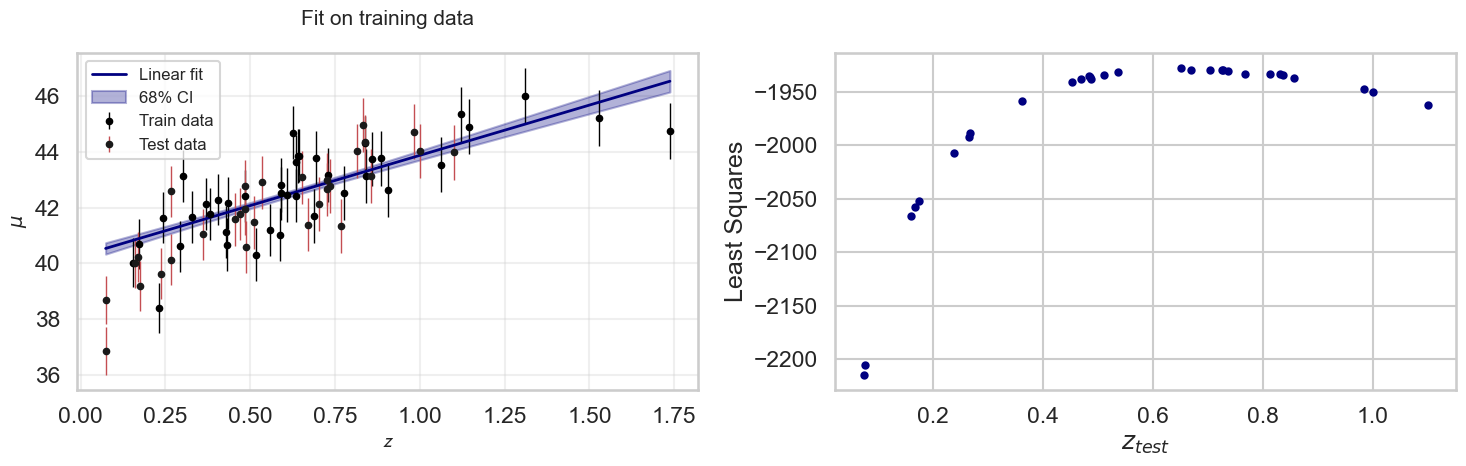

In [ ]:
x_fit = np.linspace(z_sample.min(), z_sample.max(), 1000)
y_fit = LR.predict(x_fit.reshape(-1, 1))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.', color='black', ecolor='black', lw=1, label='Train data')
plt.errorbar(X_test[:, 0], X_test[:, 1], yerr=X_test[:, 2], fmt='.', color='k', ecolor='r', lw=1, label='Test data')
z_sorted, y_pred_sorted, ci_sorted = compute_ci(z_sample, mu_sample, LR.predict(z_sample.reshape(-1, 1)))
plt.plot(z_sorted, y_pred_sorted, color='navy', lw=2, label='Linear fit')
plt.fill_between(z_sorted, y_pred_sorted - ci_sorted, y_pred_sorted + ci_sorted, color='navy', alpha=0.3, label='68% CI')
plt.xlabel(r"$\mathcal{z}$", fontsize=14)
plt.ylabel(r"$\mu$", fontsize=14)
plt.title("Fit on training data", fontsize=15)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
residuals = (X_test[:,1] - LR.predict(X_test[:, 0].reshape(-1,1))**2)/X_test[:, 2]**2
plt.scatter(X_test[:, 0], residuals, marker='.', color='navy')
plt.ylabel('Least Squares')
plt.xlabel(r'$z_{test}$')
plt.tight_layout()




Test score : $1 - \frac{u}{v} = \frac{\sum_{i=1}^{N}(y_{t,i} - y_{p,i})^2}{\sum_{i=1}^{N}(y_{t,i} - <y_{t}>)^2}$

In [168]:
from sklearn.metrics import mean_squared_error
print(f'Test score : {mean_squared_error(X_test[:, 1],LR.predict(X_test[:, 0].reshape(-1,1))):.3}')

Test score : 1.38


## Polynomial Regression

1. Define polinomial degrees to fit the data with
2. Train models on training set and compute RMSE_train
3. Perform K-Fold Cross validation and compute RMSE_cv
4. Plot results
5. Plot errors vs degree

In [169]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import learning_curve

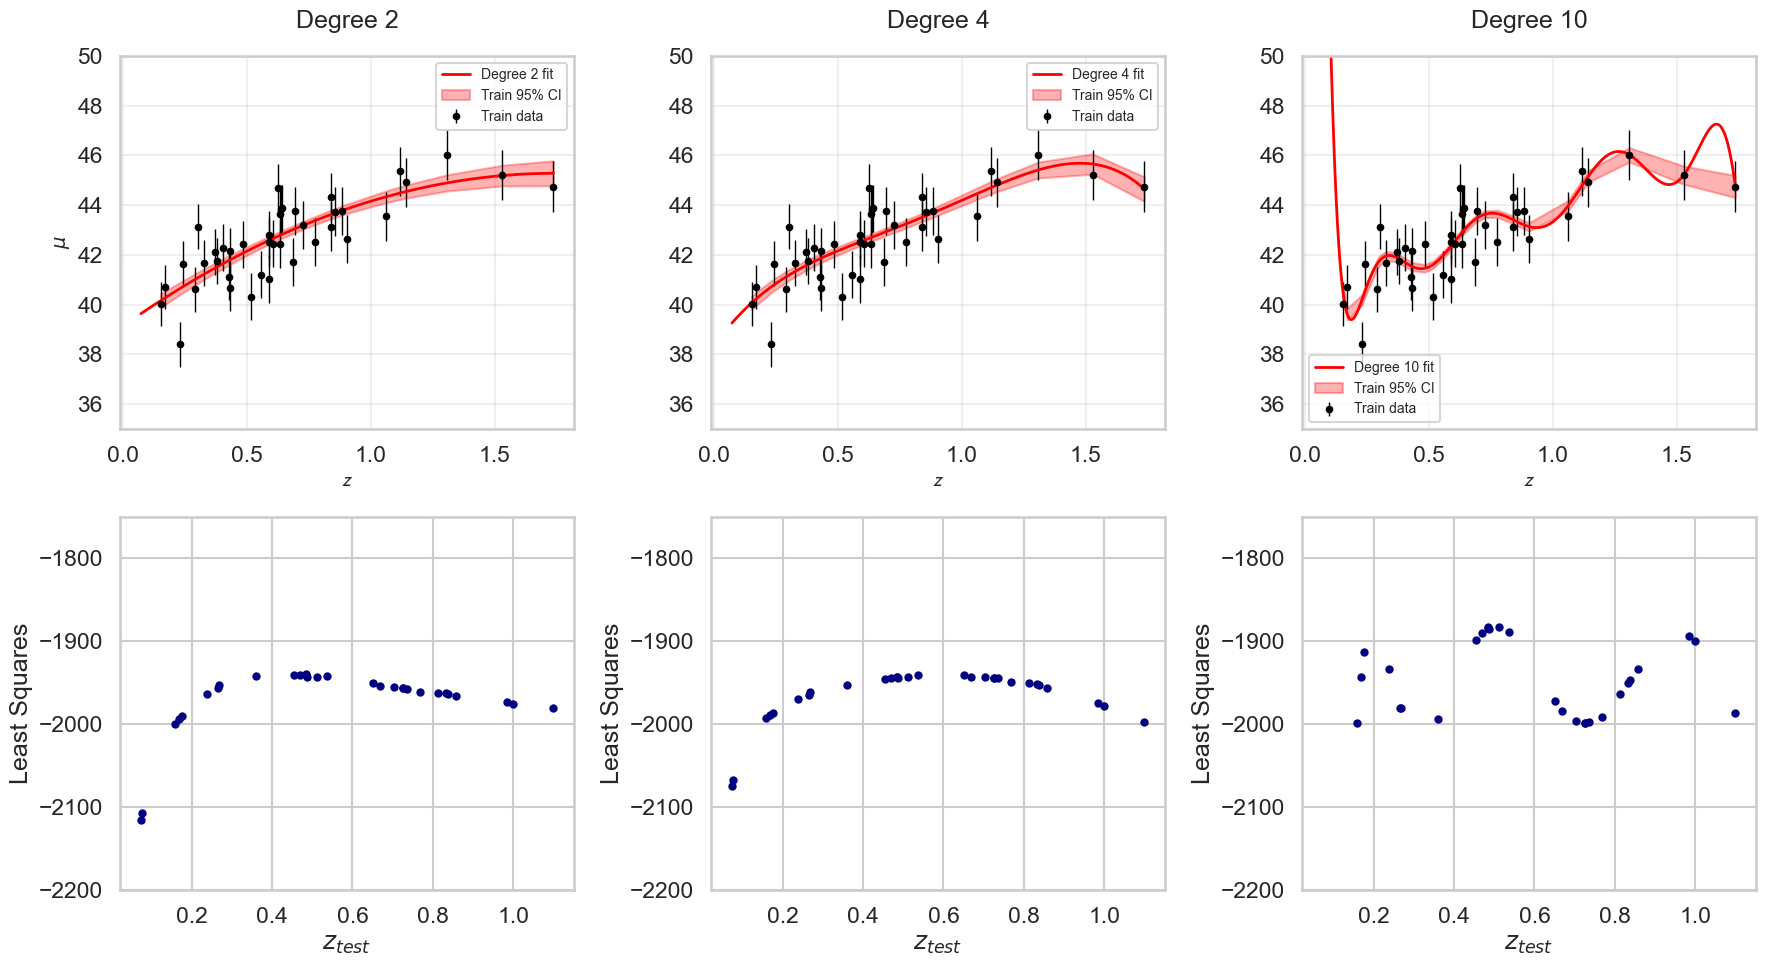

In [170]:
degrees = [2, 4, 10]
fig, axes = plt.subplots(2, len(degrees), figsize=(6 * len(degrees), 10))

for i, deg in enumerate(degrees):
    ax = axes[0][i]
    
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=deg)),
        ('linear', LinearRegression())
    ])
    model.fit(X_train[:, 0].reshape(-1, 1), X_train[:, 1])

    y_fit = model.predict(x_fit.reshape(-1,1))
    y_test_pred = model.predict(X_test[:, 0].reshape(-1, 1))
    
    ax.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.', color='black', ecolor='black', lw=1, label='Train data')
    ax.plot(x_fit, y_fit, color='red', lw=2, label=f'Degree {deg} fit')    
    z_sorted, y_pred_sorted, ci_sorted = compute_ci(X_train[:, 0], X_train[:, 1], model.predict(X_train[:, 0].reshape(-1, 1)))
    ax.fill_between(z_sorted, y_pred_sorted - ci_sorted, y_pred_sorted + ci_sorted, 
                    color='red', alpha=0.3, label='Train 95% CI')

    ax.set_title(f"Degree {deg}")
    ax.set_xlabel(r"$\mathcal{z}$", fontsize=14)
    if i == 0:
        ax.set_ylabel(r"$\mu$", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(35, 50)          # <-- set ylim for first row here
    
    ax.legend(fontsize=10)
    
    bx = axes[1][i]
    residuals = ((X_test[:,1]) - model.predict(X_test[:, 0].reshape(-1,1))**2)/X_test[:, 2]**2
    bx.scatter(X_test[:, 0], residuals, marker='.', color='navy')
    bx.set_ylabel('Least Squares')
    bx.set_xlabel(r'$z_{test}$')
    bx.set_ylim(-2200, -1750)   # <-- set ylim for second row here

plt.tight_layout()
plt.show()


As shown in the plot above, a $2^{th}$ degree polynomial is ok, a $4^{th}$ degree polynomial captures more of the data structure without being greatly influenced by the data variance, as the $10^{th}$ degree polynomial does. For a more quantitative analysis, I'll cross validate

In [171]:
pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

param_grid = {'poly__degree': list(np.linspace(1,10,10,dtype=int))}

custom_cv = KFold(n_splits=5, shuffle=True, random_state=420)

grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='neg_mean_squared_error', return_train_score=True, refit=True)
grid.fit(X_cv[:, 0].reshape(-1, 1), X_cv[:, 1])

best_degree = grid.best_params_['poly__degree']

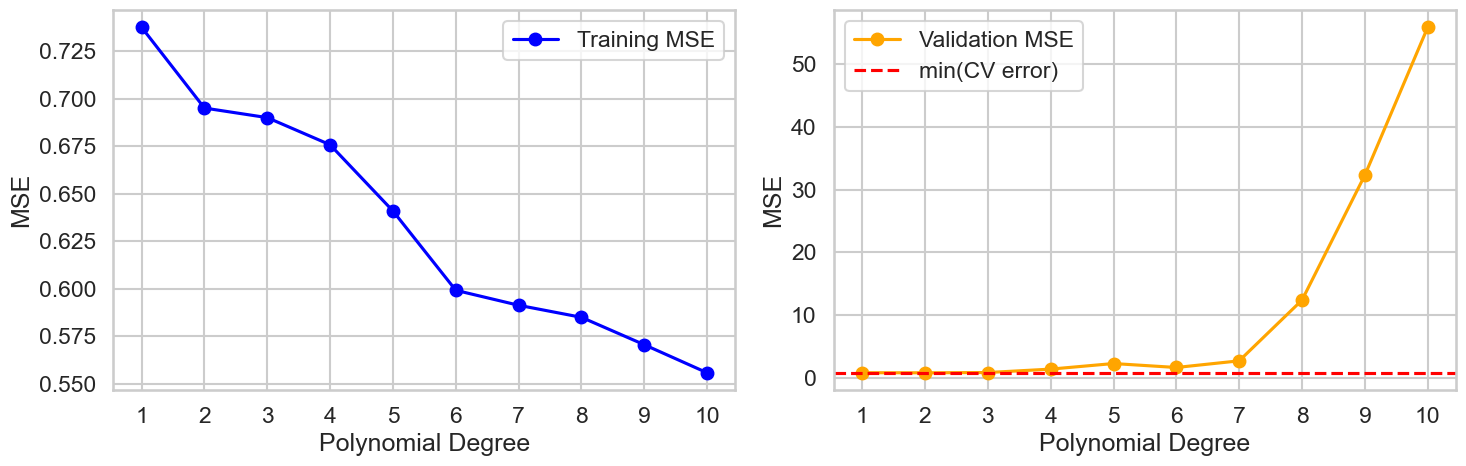

In [172]:
degrees = grid.cv_results_['param_poly__degree'].data
train_rmse = np.sqrt(-grid.cv_results_['mean_train_score'])
val_rmse = np.sqrt(-grid.cv_results_['mean_test_score'])

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(degrees, train_rmse, 'o-', label='Training MSE', color='blue')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.xticks(degrees)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(degrees, val_rmse, 'o-', label='Validation MSE', color='orange')
plt.axhline(np.min(val_rmse), 0, 1, color='red', linestyle='--', label='min(CV error)')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.xticks(degrees)
plt.legend()
#plt.yscale('log')
plt.grid(True)
plt.tight_layout()

As showed in the plots above, as the polynomial degree increases, the training MSE decreases since the number of parameters grows and thus it is easier for the model to best fit the data. At the same time CV MSE increases after $4^{th}$ degree. But how does the model perform with unseen data (namely test set)?

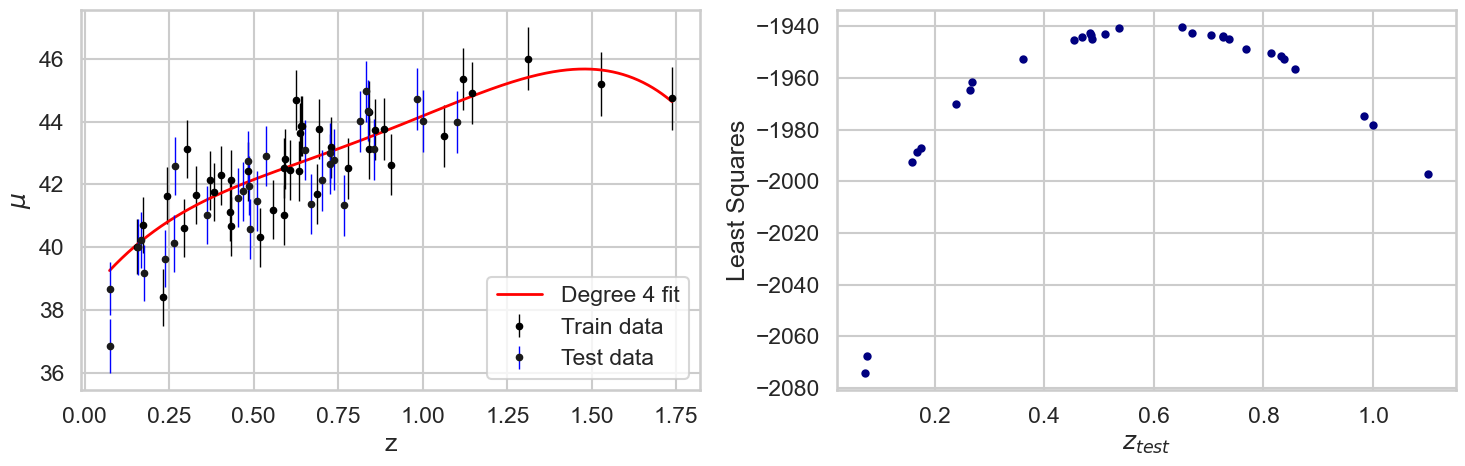

In [194]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('linear', LinearRegression())
])
model.fit(X_train[:, 0].reshape(-1, 1), X_train[:, 1])

y_fit = model.predict(x_fit.reshape(-1,1))

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.', color='black', ecolor='black', lw=1, label='Train data')
plt.plot(x_fit, y_fit, color='red', lw=2, label=f'Degree {4} fit')
plt.errorbar(X_test[:, 0], X_test[:, 1], yerr=X_test[:, 2], fmt='.', color='k', ecolor='blue', lw=1, label='Test data')
#z_sorted, y_pred_sorted, ci_sorted = compute_ci(X_train[:, 0], X_train[:, 1], model.predict(X_train[:, 0].reshape(-1, 1)))
#plt.fill_between(z_sorted, y_pred_sorted - ci_sorted, y_pred_sorted + ci_sorted, 
                #color='red', alpha=0.3, label='Test 95% CI')
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$\mu$')

plt.subplot(1, 2, 2)
residuals = (X_test[:,1] - model.predict(X_test[:, 0].reshape(-1,1))**2)/X_test[:, 2]**2
plt.scatter(X_test[:, 0], residuals, marker='.', color='navy')
plt.ylabel('Least Squares')
plt.xlabel(r'$z_{test}$')
plt.tight_layout()

In [191]:
y_test_pred = model.predict(X_test[:, 0].reshape(-1, 1))
mse = mean_squared_error(X_test[:, 1], y_test_pred)

print(f"Test score (MSE): {mse:.3f}")

Test score (MSE): 0.902


# Optional

## Basis Function Regression (Gaussians)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianBasis(BaseEstimator, TransformerMixin):
    def __init__(self, n_centers=10, sigma=1.0):
        self.n_centers = n_centers
        self.sigma = sigma

    def fit(self, X, y=None):
        X = X.reshape(-1, 1)
        self.centers_ = np.linspace(X.min(), X.max(), self.n_centers).reshape(-1, 1)
        return self

    def transform(self, X):
        X = X.reshape(-1, 1)
        return np.exp(-((X - self.centers_.T) ** 2) / (2 * self.sigma ** 2))

In [197]:
pipe = Pipeline([
    ('gauss', GaussianBasis()),  
    ('linreg', LinearRegression())
])

param_grid = {
    'gauss__n_centers': list(np.linspace(1, 20, 20, dtype=int)),
    'gauss__sigma': list(np.power(10, np.linspace(-3, 0, 7)))
}

# Fit GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='neg_mean_squared_error', verbose=3)
grid.fit(X_train[:, 0].reshape(-1, 1), X_train[:, 1])

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV 1/5] END gauss__n_centers=1, gauss__sigma=0.001;, score=-0.964 total time=   0.0s
[CV 2/5] END gauss__n_centers=1, gauss__sigma=0.001;, score=-1.948 total time=   0.0s
[CV 3/5] END gauss__n_centers=1, gauss__sigma=0.001;, score=-4.083 total time=   0.0s
[CV 4/5] END gauss__n_centers=1, gauss__sigma=0.001;, score=-3.901 total time=   0.0s
[CV 5/5] END gauss__n_centers=1, gauss__sigma=0.001;, score=-2.566 total time=   0.0s
[CV 1/5] END gauss__n_centers=1, gauss__sigma=0.0031622776601683794;, score=-0.964 total time=   0.0s
[CV 2/5] END gauss__n_centers=1, gauss__sigma=0.0031622776601683794;, score=-1.948 total time=   0.0s
[CV 3/5] END gauss__n_centers=1, gauss__sigma=0.0031622776601683794;, score=-4.083 total time=   0.0s
[CV 4/5] END gauss__n_centers=1, gauss__sigma=0.0031622776601683794;, score=-3.901 total time=   0.0s
[CV 5/5] END gauss__n_centers=1, gauss__sigma=0.0031622776601683794;, score=-2.566 total time=   0.

,estimator,Pipeline(step...egression())])
,param_grid,"{'gauss__n_centers': [np.int64(1), np.int64(2), ...], 'gauss__sigma': [np.float64(0.001), np.float64(0....2776601683794), ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_centers,np.int64(2)


In [198]:
best_model = grid.best_estimator_
best_params = grid.best_params_
print(f"Best Gaussian basis parameters: {best_params}")

Best Gaussian basis parameters: {'gauss__n_centers': np.int64(2), 'gauss__sigma': np.float64(1.0)}


In [199]:
y_test_pred = best_model.predict(X_test[:, 0].reshape(-1, 1))
mse = mean_squared_error(X_test[:, 1], y_test_pred)

print(f"Test score (MSE): {mse:.3f}")

Test score (MSE): 1.083


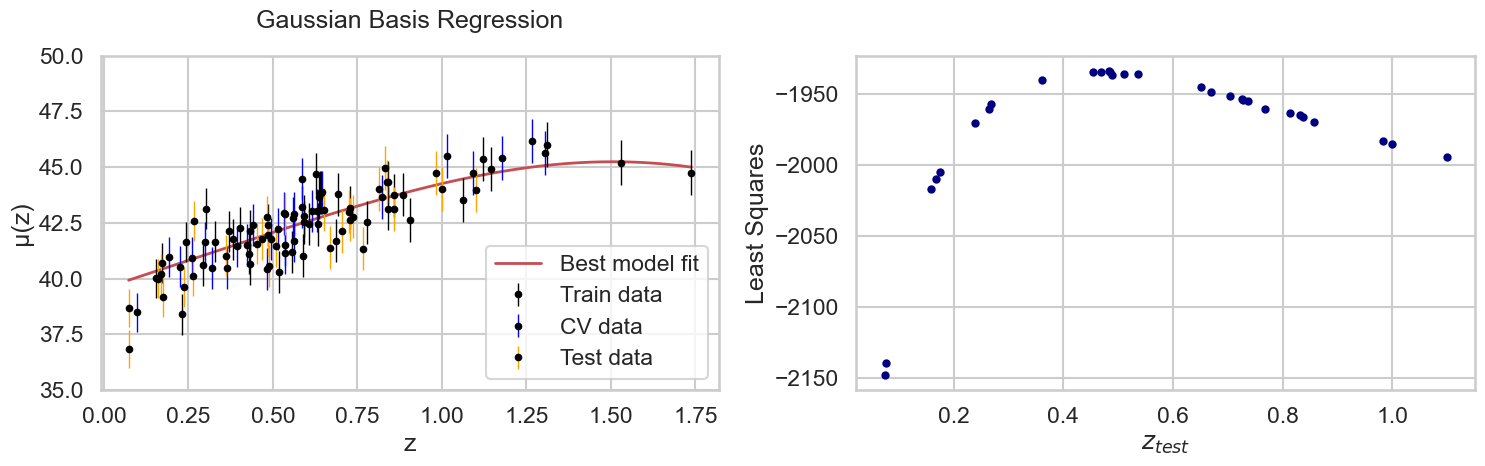

In [200]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
z_fit = np.linspace(z_sample.min(), z_sample.max(), 500).reshape(-1, 1)
mu_pred = best_model.predict(z_fit)
plt.plot(z_fit, mu_pred, 'r', lw=2, label="Best model fit")
plt.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.', color='black', ecolor='black', lw=1, label='Train data')
plt.errorbar(X_cv[:, 0], X_cv[:, 1], yerr=X_cv[:, 2], fmt='.', color='black', ecolor='blue', lw=1, label='CV data')
plt.errorbar(X_test[:, 0], X_test[:, 1], yerr=X_test[:, 2], fmt='.', color='black', ecolor='orange', lw=1, label='Test data')
plt.xlabel("z")
plt.ylabel("μ(z)")
plt.title("Gaussian Basis Regression")
plt.legend()
plt.ylim(35,50)

plt.subplot(1, 2, 2)
residuals = (X_test[:,1] - best_model.predict(X_test[:, 0].reshape(-1,1))**2)/X_test[:, 2]**2
plt.scatter(X_test[:, 0], residuals, marker='.', color='navy')
plt.ylabel('Least Squares')
plt.xlabel(r'$z_{test}$')
plt.tight_layout()

In [201]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train[:, 0].reshape(-1, 1), X_train[:, 1],
    cv=custom_cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.4, 1.0, 10),
    verbose=1
)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

[learning_curve] Training set sizes: [12 14 17 19 21 23 25 27 29 32]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


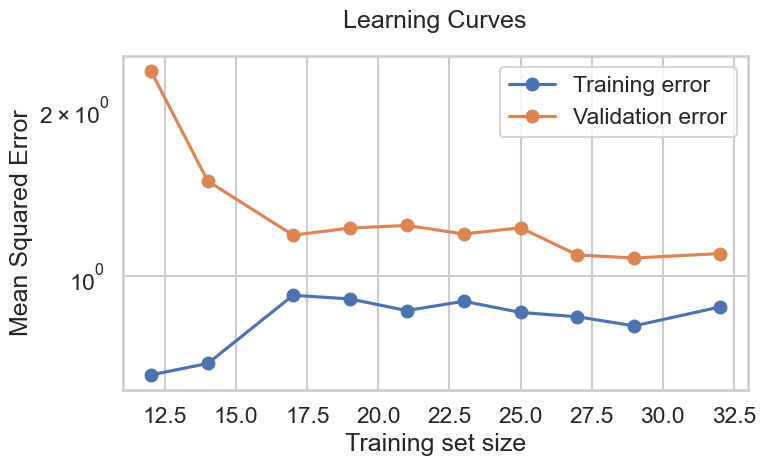

In [202]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training error")
plt.plot(train_sizes, val_scores_mean, 'o-', label="Validation error")
plt.xlabel("Training set size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curves")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Looking at learning curves, I can see that the RMSE errors on training and validation converge, but the error value overall is still high! This means that increasing the training set dimension is not usefull....I'd need a more complex model

In [203]:
y_test_pred = model.predict(X_test[:, 0].reshape(-1, 1))
mse = mean_squared_error(X_test[:, 1], y_test_pred)

print(f"Test score (MSE): {mse:.3f}")

Test score (MSE): 0.902


## Kernel regression (Nadaraya-Watson)

In [204]:
from astroML.linear_model import NadarayaWatson

In [205]:
# Define the bandwidth values to try
param_grid = {'h': list(np.power(10, np.linspace(-1,1,20)))}

# Perform 5-fold cross-validation
grid = GridSearchCV(NadarayaWatson(kernel='gaussian'), param_grid, cv=custom_cv, scoring='neg_mean_squared_error')

# Fit on training data
grid.fit(X_train[:, 0].reshape(-1, 1), X_train[:, 1])

# Best model and bandwidth
best_model = grid.best_estimator_
best_bandwidth = grid.best_params_['h']
print("Best bandwidth:", best_bandwidth)


Best bandwidth: 0.1


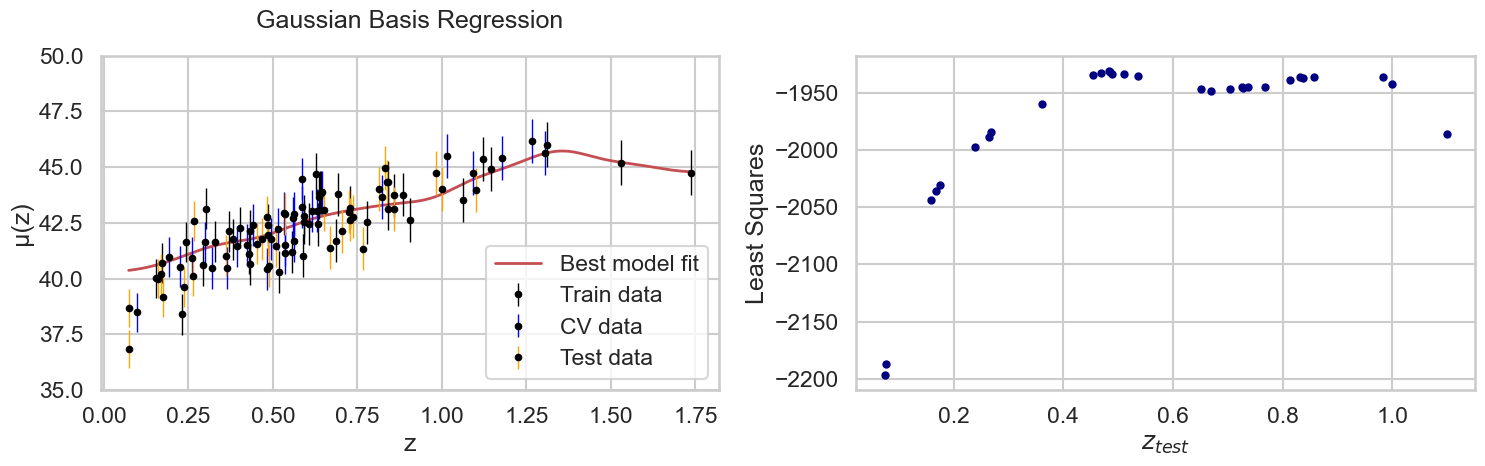

In [207]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
z_fit = np.linspace(z_sample.min(), z_sample.max(), 500).reshape(-1, 1)
mu_pred = best_model.predict(z_fit)
plt.plot(z_fit, mu_pred, 'r', lw=2, label="Best model fit")
plt.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.', color='black', ecolor='black', lw=1, label='Train data')
plt.errorbar(X_cv[:, 0], X_cv[:, 1], yerr=X_cv[:, 2], fmt='.', color='black', ecolor='blue', lw=1, label='CV data')
plt.errorbar(X_test[:, 0], X_test[:, 1], yerr=X_test[:, 2], fmt='.', color='black', ecolor='orange', lw=1, label='Test data')
plt.xlabel("z")
plt.ylabel("μ(z)")
plt.title("Gaussian Basis Regression")
plt.legend()
plt.ylim(35,50)

plt.subplot(1, 2, 2)
residuals = (X_test[:,1] - best_model.predict(X_test[:, 0].reshape(-1,1))**2)/X_test[:, 2]**2
plt.scatter(X_test[:, 0], residuals, marker='.', color='navy')
plt.ylabel('Least Squares')
plt.xlabel(r'$z_{test}$')
plt.tight_layout()

In [208]:
y_test_pred = best_model.predict(X_test[:, 0].reshape(-1, 1))
mse = mean_squared_error(X_test[:, 1], y_test_pred)

print(f"Test score (MSE): {mse:.3f}")

Test score (MSE): 1.318


In [209]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train[:, 0].reshape(-1, 1), X_train[:, 1],
    cv=custom_cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=1
)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

[learning_curve] Training set sizes: [ 3  6  9 12 16 19 22 25 28 32]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


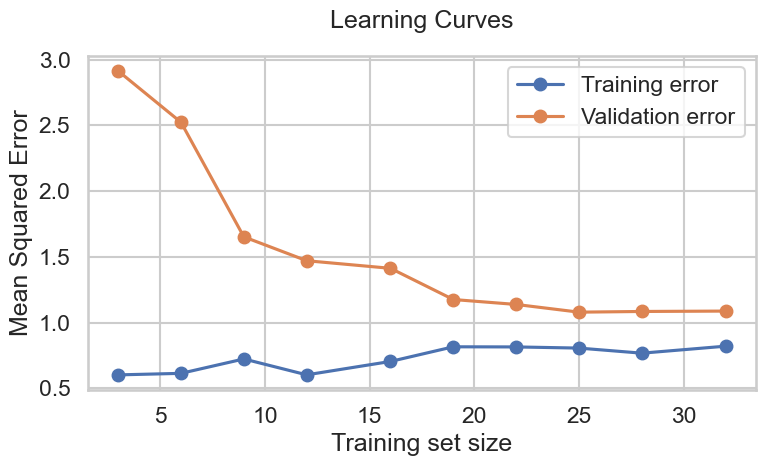

In [210]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training error")
plt.plot(train_sizes, val_scores_mean, 'o-', label="Validation error")
plt.xlabel("Training set size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()